In [1]:
# 변수의 shape, type, value 확인
def p(var,_name="") :
    if _name != "" : print(f'<<{_name}>>')
    if type(var)!=type([]):
        try:
            print(f'Shape:{var.shape}')
        except :
            pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}')

def pst(_x,_name=""):
    print(f'<<{_name}>> Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'<<{_name}>> Shape{_x.shape}')

# LangGraph Parallel Agent

In [2]:
%%time
!pip install -q langgraph langchain langchain-openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 754.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 17.1 MB/s eta 0:00:00
CPU times: user 2.3 s, sys: 1.12 s, total: 3.42 s
Wall time: 9.25 s


In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
import os
from google.colab import userdata

# OpenAI API 키는 필요시 설정 (이번 실습에서는 사용하지 않음)
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

* Graph 시각화

In [5]:
!pip install nest_asyncio -q  # Jupyter Notebook에서 비동기 실행을 위해 필요

In [6]:
from IPython.display import Image, display
import nest_asyncio

# 비동기 실행을 위해 필요
nest_asyncio.apply()

## Tool 정의

In [7]:
import json

# 가상 DB 역할을 하는 딕셔너리
mock_process_db = {
    "포토리소그래피": json.dumps({"Dose (mJ/cm^2)": 25.0, "Focus (um)": -0.05, "Validated": "Yes"}),
    "식각": json.dumps({"RF_Power (W)": 500, "Pressure (mTorr)": 10, "Validated": "Yes"})
}

def get_process_data(step_name: str) -> str:
    """DB에서 공정 데이터를 조회하는 툴"""
    print(f"--- TOOL: get_process_data(step_name='{step_name}') 실행 ---")
    return mock_process_db.get(step_name, "해당 공정 데이터를 찾을 수 없습니다.")

# 가상 매뉴얼 파일 생성
with open("DUV_manual.txt", "w", encoding="utf-8") as f:
    f.write("DUV 공정의 핵심은 193nm 파장의 빛을 사용하여 미세 패턴을 형성하는 것입니다.")

def load_manual(path: str) -> str:
    """매뉴얼 파일을 로딩하는 툴"""
    print(f"--- TOOL: load_manual(path='{path}') 실행 ---")
    try:
        with open(path, 'r', encoding='utf-8') as f:
            return f.read()
    except FileNotFoundError:
        return f"파일을 찾을 수 없습니다: {path}"

## Graph Workflow 뼈대   
> 가장 기본적인 '계획(Plan) -> 실행(Execute)' 흐름을 가진 2단계 그래프




### Graph State 및 Node 정의  
> LangGraph의 모든 노드는 상태(State) 객체를 공유하며 정보를 주고받음   
이 상태의 구조를 정의하고,
각 상태를 변화시키는 함수(노드)들을 정의 함  

In [8]:
from typing import TypedDict, Annotated, List
from langchain_openai import ChatOpenAI

## 그래프의 상태 정의
# 각 노드를 거치면서 이 상태 객체의 값들이 변경
class AgentState(TypedDict):
    query: str             # 사용자의 원본 질문
    plan: List[str]        # LLM이 생성한 실행 계획
    tool_results: List[str]# 각 도구의 실행 결과
    final_answer: str      # 최종 답변

## LLM 초기화
llm = ChatOpenAI(model="gpt-4o", temperature=0)

## 각 노드가 될 함수들 정의
# 쿼리를 바탕으로 실행 계획 생성
def planner_node(state: AgentState) -> dict:
    print("---노드 실행: planner_node ---")
    query = state['query']

    # 예시를 위해 고정된 계획 생성, 앞에서는 LLM으로 구현
    if "포토리소그래피" in query:
        plan = ["DB_QUERY:포토리소그래피"]*2
    else:
        plan = [f"LLM_CALL:{query}"]

    print(f"생성된 계획: {plan}")
    return {"plan": plan}   # state update

# 계획에 따라 도구를 실행
def executor_node(state: AgentState) -> dict:
    print("--- 노드 실행: executor_node ---")
    results = []
    for step in state['plan']:
        if step.startswith("DB_QUERY:"): # str이 "--"로 시작되는가?
            _, step_name = step.split(":", 1)
            results.append(get_process_data(step_name))
        else: # LLM_CALL 또는 기타
             _, prompt = step.split(":", 1)
             # 실제로는 여기서 LLM을 호출해야 하지만, 예제 단순화를 위해 문자열을 반환
             results.append(f"'{prompt}'에 대한 설명을 생성했습니다.")
    return {"tool_results": results}

### 그래프 구성 및 실행  
> 정의한 상태와 노드들을 StateGraph에 추가하고,  
엣지로 연결하여 워크플로우를 완성

In [9]:
from langgraph.graph import StateGraph, END

# 그래프 워크플로우 정의
workflow = StateGraph(AgentState)

# 노드 추가
workflow.add_node("planner", planner_node)
workflow.add_node("executor", executor_node)

# 엣지 추가 (어떤 노드 다음에 어떤 노드가 실행될지)
workflow.set_entry_point("planner") # 시작점 지정
workflow.add_edge("planner", "executor")
workflow.add_edge("executor", END) # 끝점 지정

# 그래프 컴파일
app = workflow.compile()

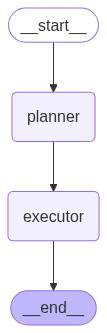

In [10]:
display(Image(app.get_graph().draw_mermaid_png()))

In [11]:
# 실행 및 결과 확인
input_data = {"query": "포토리소그래피 파라미터 알려줘"}
for event in app.stream(input_data):
    print(f"event:{event}")
    for key, value in event.items():  # (node, return)
        print(f"--- 스트림 이벤트: 노드 '{key}' 실행 완료 ---")
        print(value,'\n')

---노드 실행: planner_node ---
생성된 계획: ['DB_QUERY:포토리소그래피', 'DB_QUERY:포토리소그래피']
event:{'planner': {'plan': ['DB_QUERY:포토리소그래피', 'DB_QUERY:포토리소그래피']}}
--- 스트림 이벤트: 노드 'planner' 실행 완료 ---
{'plan': ['DB_QUERY:포토리소그래피', 'DB_QUERY:포토리소그래피']} 

--- 노드 실행: executor_node ---
--- TOOL: get_process_data(step_name='포토리소그래피') 실행 ---
--- TOOL: get_process_data(step_name='포토리소그래피') 실행 ---
event:{'executor': {'tool_results': ['{"Dose (mJ/cm^2)": 25.0, "Focus (um)": -0.05, "Validated": "Yes"}', '{"Dose (mJ/cm^2)": 25.0, "Focus (um)": -0.05, "Validated": "Yes"}']}}
--- 스트림 이벤트: 노드 'executor' 실행 완료 ---
{'tool_results': ['{"Dose (mJ/cm^2)": 25.0, "Focus (um)": -0.05, "Validated": "Yes"}', '{"Dose (mJ/cm^2)": 25.0, "Focus (um)": -0.05, "Validated": "Yes"}']} 



```python
# event 객체
{
  'planner': {
    'query': '포토리소그래피 파라미터 알려줘',
    'plan': ['DB_QUERY:포토리소그래피'],  # planner 노드가 이 값을 추가함
    'tool_results': None,
    'final_answer': None
  }
}
```

## 병렬 분기 및 결과 병합  
### 하나의 입력에 대해 DB 조회와 매뉴얼 로딩을 동시에 실행하고, 그 결과 합치기  


### 병렬 처리용 노드 정의



In [12]:
# 병렬 처리를 위한 새로운 상태 정의
class ParallelState(TypedDict):
    query: str
    db_result: str
    manual_result: str
    final_summary: str

# 각자 다른 작업을 수행하는 병렬 노드들
def db_node(state: ParallelState) -> dict:
    print("--- 노드 실행: db_node ---")
    return {"db_result": get_process_data(state['query'])}

def manual_node(state: ParallelState) -> dict:
    print("--- 노드 실행: manual_node ---")
    # 실제로는 쿼리에서 파일명을 추출해야 하지만, 예제 단순화를 위해 고정
    return {"manual_result": load_manual("DUV_manual.txt")}

# 병렬 노드들의 결과를 종합하여 최종 답변 생성
def merge_node(state: ParallelState) -> dict:
    print("--- 노드 실행: merge_node ---")
    prompt = f"""
다음 두 가지 정보를 종합하여 사용자의 질문에 대한 최종 요약 답변을 생성해주세요.
질문: {state['query']}에 대한 정보 요약

DB 정보: {state['db_result']}
매뉴얼 정보: {state['manual_result']}

종합 요약:
"""
    summary = llm.invoke(prompt).content
    return {"final_summary": summary}

### 병렬 그래프 구성 및 실행
>add_edge를 사용하여 한 노드에서 여러 노드로 엣지를 연결하면,   
해당 노드들이 병렬로 실행

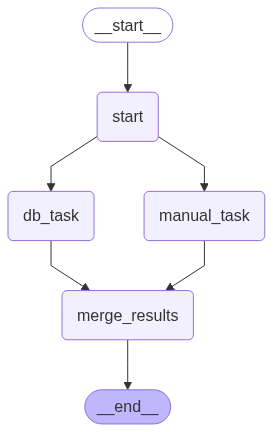

In [13]:
# 새로운 병렬 그래프 정의
parallel_workflow = StateGraph(ParallelState)

# 시작점으로 사용할 더미 노드 (입력을 받아서 분기로 전달)
parallel_workflow.set_entry_point("start")
parallel_workflow.add_node("start", lambda state: {})# dummy node 꼭 필요함

# 병렬로 실행될 노드들 추가
parallel_workflow.add_node("db_task", db_node)
parallel_workflow.add_node("manual_task", manual_node)

# 결과 병합 노드 추가
parallel_workflow.add_node("merge_results", merge_node)

# 엣지 연결
parallel_workflow.add_edge("start", "db_task")       # start -> db_task
parallel_workflow.add_edge("start", "manual_task")   # start -> manual_task
parallel_workflow.add_edge("db_task", "merge_results")    # db_task -> merge_results
parallel_workflow.add_edge("manual_task", "merge_results")# manual_task가 -> merge_results

# 병합 노드 이후 종료
parallel_workflow.add_edge("merge_results", END)
# 컴파일 및 실행
parallel_app = parallel_workflow.compile()

display(Image(parallel_app.get_graph().draw_mermaid_png()))

In [14]:
final_state = parallel_app.invoke({"query": "포토리소그래피"})

print("\n--- 최종 실행 결과 ---")
print(final_state['final_summary'])

--- 노드 실행: db_node ---
--- TOOL: get_process_data(step_name='포토리소그래피') 실행 ---
--- 노드 실행: manual_node ---
--- TOOL: load_manual(path='DUV_manual.txt') 실행 ---
--- 노드 실행: merge_node ---

--- 최종 실행 결과 ---
포토리소그래피는 미세 패턴을 형성하기 위해 빛을 사용하는 공정으로, 특히 DUV(Deep Ultraviolet) 공정에서는 193nm 파장의 빛이 사용됩니다. 이 공정에서 중요한 매개변수로는 노광량(Dose)과 초점(Focus)이 있으며, 예를 들어 노광량은 25.0 mJ/cm^2, 초점은 -0.05 µm로 설정될 수 있습니다. 이러한 조건은 검증된(Validated) 것으로, 정확한 패턴 형성을 위해 필수적입니다.


## 대규모 협업 시나리오  
###  '감독(Coordinator)' 노드가 사용자의 복잡한 요청을 분석하여 여러 개의 하위 작업으로 나눈 뒤,  
### 각 작업을 '작업자(Worker)' 노드에 분배하여 처리하고,   
### 마지막에 결과를 종합하는 '멀티 에이전트 협업' 패턴 구현

### 감독-작업자 (Supervisor-Worker) 패턴   

1. 감독 (Coordinator):  
사용자의 복잡한 요청(예: "A도 해주고 B도 찾아줘")을 받습니다. LLM을 사용하여 이 요청을 단일 작업을 수행하는 여러 개의 명확한 지시사항(sub-tasks)으로 분해합니다. (예: ['A 작업 지시', 'B 작업 지시'])
2.작업자 (Worker):  
분배된 개별 지시사항을 받아, 각자 맡은 도구를 사용하여 작업을 실행합니다.  
3. 병합/요약 (Reducer/Summarizer):  
모든 작업자들이 실행을 마친 뒤, 각자의 결과물을 모아 최종적으로 하나의 종합적인 답변으로 만들어 사용자에게 제공합니다.

In [15]:
import concurrent.futures
import time

# 사용 가능한 도구들을 딕셔너리로 매핑하여 Worker가 쉽게 찾아 쓸 수 있게 합니다.
available_tools = {
    "get_process_data": get_process_data,
    "load_manual": load_manual,
}

# 협업 시나리오를 위한 상태 정의 ---
class CollaborationState(TypedDict):
    original_query: str
    tasks: List[dict]        # 감독 노드가 생성한 작업 리스트 (구조화된 딕셔너리 형태)
    results: List[str]       # 작업자 노드가 실행한 결과 리스트
    final_summary: str       # 최종 요약 답변


## 협업 그래프의 노드 함수 정의 ---
# 사용자의 원본 쿼리를 받아, 여러 작업자에게 분배할 구조화된 작업 리스트를 생성
def coordinator_node(state: CollaborationState) -> dict:
    print("--- 노드 실행: coordinator_node (작업 분배) ---")
    query = state['original_query']

    # LLM이 파싱하기 쉬운 JSON(딕셔너리) 형식으로 작업 계획을 생성하도록 프롬프트를 수정합니다.
    prompt = f"""
당신은 여러 전문가 팀을 관리하는 프로젝트 매니저입니다. 사용자의 복잡한 요청을 분석하여, 각 전문가(도구)가 처리할 수 있는 작업 목록을 생성해주세요.
응답은 반드시 'tool_name'과 'args' 딕셔너리를 포함하는 JSON 객체들의 리스트 형식으로만 생성해야 합니다.

# 사용 가능한 도구 명세:
- `get_process_data(step_name: str)`: 데이터베이스에서 공정 데이터를 조회합니다.
- `load_manual(path: str)`: 매뉴얼 파일을 읽습니다.

# 요청: {query}
# 작업 계획 (JSON 리스트 형식):
"""
    response = llm.invoke(prompt).content

    # LLM 응답에서 Markdown 코드 블록 제거 및 파싱
    cleaned_content = response.strip().replace("```json", "").replace("```", "").strip()
    tasks = json.loads(cleaned_content)

    print(f"생성된 구조화된 작업 리스트: {tasks}")
    return {"tasks": tasks}


## 병렬 처리를 위한 Worker 노드
# 각 스레드에서 실행될 단일 작업 처리 함수
# 구조화된 단일 작업을 받아, 적절한 도구를 실행하고 결과를 반환
def run_single_task(task: dict) -> str:
    tool_name = task.get("tool_name")
    args = task.get("args", {})

    if tool_name in available_tools:
        tool_function = available_tools[tool_name]
        # **args는 {'step_name': '식각'}을 step_name='식각'으로 풀어줍니다
        return tool_function(**args)
    else:
        return f"알 수 없는 도구: {tool_name}"

# 병렬 실행 로직을 포함한 새로운 worker_node
# 분배된 작업 리스트를 '병렬'로 실행
def parallel_worker_node(state: CollaborationState) -> dict:
    print("--- 노드 실행: parallel_worker_node (병렬 작업 처리) ---")
    tasks = state['tasks']
    results = []

    # ThreadPoolExecutor를 사용하여 run_single_task 함수를 각 task에 병렬로 적용
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # executor.map은 tasks 리스트의 각 항목을 run_single_task 함수에 전달하고,
        # 모든 스레드가 완료될 때까지 기다린 후 결과 리스트를 반환합니다.
        results = list(executor.map(run_single_task, tasks))

    return {"results": results}

def reducer_node(state: CollaborationState) -> dict:
    """모든 작업 결과를 종합하여 최종 답변을 생성합니다."""
    print("--- 노드 실행: reducer_node (결과 종합) ---")
    query = state['original_query']
    results_str = "\n---\n".join(state['results'])

    prompt = f"""
사용자의 원본 요청과 각 전문가가 수행한 작업 결과가 아래에 있습니다.
이 정보들을 모두 종합하여 사용자에게 제공할 최종 보고서를 자연스러운 문장으로 작성해주세요.

# 원본 요청: {query}
# 작업 결과:
{results_str}

# 최종 종합 보고서:
"""
    summary = llm.invoke(prompt).content
    return {"final_summary": summary}

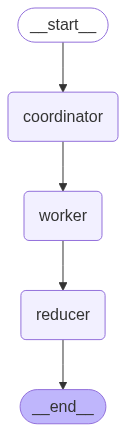

In [16]:
# 병렬 그래프 구성
# coordinator_node와 reducer_node는 이전과 동일하게 사용

parallel_collab_workflow = StateGraph(CollaborationState)

# 노드 추가
parallel_collab_workflow.add_node("coordinator", coordinator_node)
parallel_collab_workflow.add_node("worker", parallel_worker_node)
parallel_collab_workflow.add_node("reducer", reducer_node)

# 엣지 연결
parallel_collab_workflow.set_entry_point("coordinator")
parallel_collab_workflow.add_edge("coordinator", "worker")
parallel_collab_workflow.add_edge("worker", "reducer")
parallel_collab_workflow.add_edge("reducer", END)

parallel_collab_app = parallel_collab_workflow.compile()
display(Image(parallel_collab_app.get_graph().draw_mermaid_png()))

In [17]:
# 검증 ---
complex_query_parallel = "DUV 공정 매뉴얼의 내용과, 식각 공정의 DB 데이터를 함께 알려줘"
print(f"--- 병렬 협업 에이전트 실행 (요청: {complex_query_parallel}) ---\n")

start_time = time.time()
final_parallel_result = parallel_collab_app.invoke({"original_query": complex_query_parallel})
end_time = time.time()

print(f"\n\n--- 최종 실행 결과 (소요 시간: {end_time - start_time:.2f}초) ---")
print(final_parallel_result['final_summary'])



--- 병렬 협업 에이전트 실행 (요청: DUV 공정 매뉴얼의 내용과, 식각 공정의 DB 데이터를 함께 알려줘) ---

--- 노드 실행: coordinator_node (작업 분배) ---
생성된 구조화된 작업 리스트: [{'tool_name': 'load_manual', 'args': {'path': 'DUV_공정_매뉴얼.pdf'}}, {'tool_name': 'get_process_data', 'args': {'step_name': '식각'}}]
--- 노드 실행: parallel_worker_node (병렬 작업 처리) ---
--- TOOL: load_manual(path='DUV_공정_매뉴얼.pdf') 실행 ---
--- TOOL: get_process_data(step_name='식각') 실행 ---
--- 노드 실행: reducer_node (결과 종합) ---


--- 최종 실행 결과 (소요 시간: 4.03초) ---
죄송합니다. 요청하신 DUV 공정 매뉴얼 파일을 찾을 수 없었습니다. 그러나 식각 공정의 데이터는 다음과 같습니다: RF 파워는 500W, 압력은 10mTorr이며, 이 데이터는 검증된 것으로 확인되었습니다. 추가적인 정보가 필요하시면 다른 요청을 해주시기 바랍니다.


## Error 처리 추가  
### DB 조회 시, 찾는 데이터가 없으면 오류가 발생했다고 가정하고,이 때 LLM을 호출하여 대안적인 설명을 생성하는 분기 생성  
> DB 조회 결과에 'error'가 포함되어 있는지 여부에 따라, 정상적으로 종료하거나 '오류 처리 노드'로 분기하도록 조건부 엣지(add_conditional_edges)를 추가하자  

### 조건부 분기 그래프  
> add_conditional_edges는 특정 함수의 반환값에 따라 다음에 실행될 노드를 동적으로 결정

In [18]:
# 조건부 분기를 위한 상태 및 노드 정의
class ConditionalState(TypedDict):
    query: str
    result: str

# DB를 조회하고, 결과가 없을 경우 'error'를 포함한 결과를 반환
def conditional_db_node(state: ConditionalState) -> dict:
    print("--- 노드 실행: conditional_db_node ---")
    query = state['query']
    result = get_process_data(query) # 없는 데이터를 조회하면 에러 문자열이 포함됨
    return {"result": result}

# 오류 발생 시 LLM을 호출하여 대안적인 답변을 생성
def fallback_node(state: ConditionalState) -> dict:
    print("--- 노드 실행: fallback_node (오류 처리) ---")
    query = state['query']
    error_message = state['result']
    prompt = f"'{query}'에 대한 데이터를 찾을 수 없습니다 ({error_message}). 대신 '{query}'가 무엇인지 일반적인 지식을 바탕으로 간단히 설명해주세요."
    fallback_answer = llm.invoke(prompt).content
    return {"result": fallback_answer}

# 분기 조건을 결정하는 함수
# state의 result 값에 'error'가 포함되어 있는지 확인하여 분기 경로를 반환
def should_fallback(state: ConditionalState) -> str:
    print("--- 조건 확인: should_fallback ---")
    if "error" in state.get("result", "") or "찾을 수 없습니다" in state.get("result", ""):
        print("-> 분기: fallback_node로 이동")
        return "fallback" # conditional_edges()에서 참조할 이름
    else:
        print("-> 분기: 정상 종료")
        return "end"      # conditional_edges()에서 참조할 이름

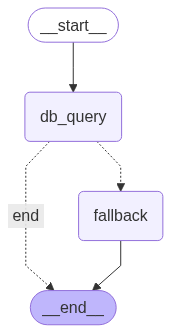

In [19]:
# 조건부 그래프 구성
conditional_workflow = StateGraph(ConditionalState)

conditional_workflow.set_entry_point("db_query")
conditional_workflow.add_node("db_query", conditional_db_node)
conditional_workflow.add_node("fallback", fallback_node)

# 조건부 엣지 추가
conditional_workflow.add_conditional_edges(
    "db_query",           # 이 노드 실행 후에 조건을 검사
    should_fallback,      # 어떤 경로로 갈지 결정하는 함수
    {
        "fallback": "fallback", # 'fallback'을 반환하면 fallback 노드로 이동
        "end": END              # 'end'를 반환하면 그래프 종료
    }
)
# fallback 노드 실행 후에는 무조건 종료
conditional_workflow.add_edge("fallback", END)

# 컴파일
conditional_app = conditional_workflow.compile()

display(Image(conditional_app.get_graph().draw_mermaid_png()))

In [20]:
# --- 검증 ---
print("--- 검증: 정상 실행 케이스 ---")
# DB에 존재하는 데이터 조회
normal_result = conditional_app.invoke({"query": "식각"})
print("\n[최종 결과]")
print(normal_result['result'])

--- 검증: 정상 실행 케이스 ---
--- 노드 실행: conditional_db_node ---
--- TOOL: get_process_data(step_name='식각') 실행 ---
--- 조건 확인: should_fallback ---
-> 분기: 정상 종료

[최종 결과]
{"RF_Power (W)": 500, "Pressure (mTorr)": 10, "Validated": "Yes"}


In [21]:
print("\n\n--- 검증: 오류 분기 케이스 ---")
# DB에 존재하지 않는 데이터 조회
error_result = conditional_app.invoke({"query": "붕어빵 레시피"})
print("\n[최종 결과]")
print(error_result['result'])



--- 검증: 오류 분기 케이스 ---
--- 노드 실행: conditional_db_node ---
--- TOOL: get_process_data(step_name='붕어빵 레시피') 실행 ---
--- 조건 확인: should_fallback ---
-> 분기: fallback_node로 이동
--- 노드 실행: fallback_node (오류 처리) ---

[최종 결과]
붕어빵은 한국의 인기 있는 길거리 음식으로, 붕어 모양의 틀에 반죽과 팥소를 넣어 구워 만드는 간식입니다. 붕어빵의 기본적인 레시피는 다음과 같습니다.

### 재료
- 밀가루: 1컵
- 베이킹 파우더: 1작은술
- 설탕: 2큰술
- 소금: 약간
- 우유: 1컵
- 계란: 1개
- 팥소 (또는 다른 소): 적당량

### 도구
- 붕어빵 틀

### 만드는 방법
1. **반죽 준비**: 큰 볼에 밀가루, 베이킹 파우더, 설탕, 소금을 넣고 잘 섞습니다. 여기에 우유와 계란을 넣고 부드럽게 섞어 반죽을 만듭니다.

2. **붕어빵 틀 예열**: 붕어빵 틀을 중간 불로 예열합니다. 틀에 기름을 살짝 발라줍니다.

3. **붕어빵 굽기**:
   - 예열된 틀에 반죽을 반쯤 채웁니다.
   - 팥소를 적당량 올립니다.
   - 그 위에 다시 반죽을 부어 팥소를 덮습니다.
   - 틀을 닫고 양쪽이 노릇노릇해질 때까지 구워줍니다. 보통 3~5분 정도 소요됩니다.

4. **완성**: 붕어빵이 다 구워지면 틀에서 꺼내어 식힘망에 올려 식힙니다.

붕어빵은 따뜻할 때 먹으면 더욱 맛있습니다. 팥소 대신 슈크림, 초콜릿, 치즈 등 다양한 소를 넣어 변형할 수도 있습니다.


# State insert

```python
### 초기 상태
state = {
    "query": "포토리소그래피가 뭐야?",
    "results": [],
    "status": "pending"
}
### node return 값
return {
    "plan": ["DB_QUERY:포토리소그래피"],
    "status": "planned"
}
### state dict. update & insert
state = {
    "query": "포토리소그래피가 뭐야?",
    "results": [],
    "status": "planned",              # 'pending' -> 'planned'로 덮어쓰기됨
    "plan": ["DB_QUERY:포토리소그래피"] # 새로운 키-값으로 추가됨
}
```